1. выделить номер
2. повернуть номер
3. выделить буквы 
4. найти готовые шаблоны(из гостовских)
5. начать распознавать буквы(завтра)
6. прикрутить к видеокамере(в будущем)
7. после этого надо будет усовершенствовать алгоритм(скорость и качество)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [59]:
def find_goal_img(contours, img, start_img):
    goal_coord = []  # Список для хранения координат найденной цели.
    goal_img = ""  # Переменная для хранения изображения цели.
    for cnt in contours:  
        x, y, w, h = cv.boundingRect(cnt)  # Получаем координаты ограничивающего прямоугольника для контура.
        rect = cv.minAreaRect(cnt)  # Получаем минимальный прямоугольник, охватывающий контур.
        box = cv.boxPoints(rect)  # Получаем координаты вершин этого прямоугольника.
        box = np.int64(box)  # Преобразуем координаты в целочисленные значения.
        if h < 32 and h > 15 and w > 103 and w < 120:  # Проверка на допустимые размеры высоты и ширины.
            if w/h > 3 and w/h < 4.8:  # Проверка на допустимые соотношения ширины к высоте.
                cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Рисуем прямоугольник вокруг цели.
                cv.drawContours(img, [box], 0, (255, 0, 0), 2)  # Рисуем контуры прямоугольника.
                goal_coord = [x, y, w, h]  # Сохраняем координаты.
                goal_rect = rect  # Сохраняем параметры минимального прямоугольника.
                goal_img = start_img[y-1:y+h, x:x+w]  # Обрезаем изображение по найденным координатам.
                break  # Прерываем цикл, так как цель найдена.
    
    if goal_coord == []: 
        return None
    # plt.imshow(img, cmap='gray')  
    # plt.show()
    # plt.imshow(goal_img, cmap='gray')  
    # plt.show()
    return find_angle(goal_img, goal_rect)  


In [60]:
# Функция для нахождения угла наклона целевого изображения
def find_angle(goal_img, goal_rect):
    height, width = goal_img.shape[:2]  # Получаем размеры изображения.
    
    center = (width // 2, height // 2)  # Вычисляем центр изображения.
    angle2 = goal_rect[2]  # Угол наклона прямоугольника.
    
    if angle2 == 90:  # Если угол равен 90, то изображение уже ориентировано корректно.
        rotated_image = goal_img
    elif 45 < angle2 < 90:  # Если угол больше 45 и меньше 90, необходимо повернуть изображение.
        rotate_matrix = cv.getRotationMatrix2D(center=center, angle=goal_rect[2] - 90, scale=1) 
        rotated_image = cv.warpAffine(src=goal_img, M=rotate_matrix, dsize=(width, height))  # Поворачиваем изображение.
    else:  # В других случаях поворачиваем на угол наклона.
        rotate_matrix = cv.getRotationMatrix2D(center=center, angle=goal_rect[2], scale=1)
        rotated_image = cv.warpAffine(src=goal_img, M=rotate_matrix, dsize=(width, height))
    
    plt.imshow(rotated_image, cmap='gray')  # Показываем повернутое изображение.
    plt.show()
    return find_symbols(rotated_image)  


In [61]:
def find_symbols(rotated_image):
    symbols = []  # Список для хранения символов.
    
    y0_start = 1  # Начальная координата по вертикали для первого символа.
    y1_start = -3  # Конечная координата по вертикали для первого символа.
    x0_start = 5  # Начальная координата по горизонтали для первого символа.
    x1_start = 24  # Конечная координата по горизонтали для первого символа.
    gap = 13  # Расстояние между символами.
    gap_numbers = 1  # Сдвиг для номера.
    
    for i in range(6):  # Проходим по 6 символам.
        first_symbol = rotated_image[y0_start:y1_start, x0_start + gap_numbers + gap * i:x1_start + gap_numbers + gap * i]
        symbols.append(first_symbol)  
        
    # Делаем второй цикл для других символов.
    y0_start = 0
    y1_start = -10
    x0_start = 3
    x1_start = 17
    gap = 10
    for i in range(1, -1, -1):
        first_symbol = rotated_image[y0_start:y1_start, -1 * (x1_start + gap_numbers + gap * i):-1 * (x0_start + gap_numbers + gap * i)]
        symbols.append(first_symbol)  

    print('size symbols: ', len(symbols)) 
    return find_match(symbols)  


In [62]:
def read_img(path_to_file, options='', show=False):
    if options != '':  
        img = cv.imread(path_to_file, options)
    else:
        img = cv.imread(path_to_file)  
    assert img is not None, "file could not be read, check with os.path.exists()"  
    if show:  
        cv.imshow("Display window", img)
    return img  


In [63]:
def find_match(symbols):
    alphabet = {'A': 0, 'B': 0, 'C': 0, 'E': 0, 'H': 0, 'K': 0, 'M': 0, 'O': 0, 'P': 0, 'T': 0, 'X': 0, 'Y': 0}
    all = []  # Список для хранения всех результатов.
   
    for j, img in enumerate(symbols):  # Перебираем все найденные символы.
        a = {}  # Словарь для хранения значений соответствий.
        tmp_max_val = 0  # Максимальное значение для соответствия.
        tmp_top_left = 0  # Координаты верхнего левого угла.
        tmp_template = ''  # Шаблон изображения.
        max_tmp_img = None  # Максимальное изображение шаблона.
        
        # Ищем соответствие для букв или цифр в зависимости от индекса символа.
        if j == 0 or j == 4 or j == 5:
            for i in alphabet:
                max_loc, max_val, template, tmp_img = matching(img, f'./Alphabhet/{i}.png', (13, 16))
                a[i] = max_val
                if tmp_max_val == 0 or tmp_max_val < max_val:
                    tmp_max_val = max_val
                    tmp_top_left = max_loc
                    tmp_template = template
                    max_tmp_img = tmp_img
        
        if j == 1 or j == 2 or j == 3:
            for i in range(10):
                max_loc, max_val, template, tmp_img = matching(img, f'./Nums/{i}.png', (13, 20))
                a[i] = max_val
                if tmp_max_val == 0 or tmp_max_val < max_val:
                    tmp_max_val = max_val
                    tmp_top_left = max_loc
                    tmp_template = template
                    max_tmp_img = tmp_img
        
        if j > 5:
            for i in range(10):
                max_loc, max_val, template, tmp_img = matching(img, f'./Nums/{i}.png', (11, 14))
                a[i] = max_val
                if tmp_max_val == 0 or tmp_max_val < max_val:
                    tmp_max_val = max_val
                    tmp_top_left = max_loc
                    tmp_template = template
                    max_tmp_img = tmp_img

        w, h = tmp_template.shape[::-1]  # Получаем размеры шаблона.
        bottom_right = (tmp_top_left[0] + w, tmp_top_left[1] + h)  # Вычисляем правый нижний угол.
        new_img = img.copy()  # Создаем копию изображения для отображения.

        # Рисуем прямоугольник вокруг найденного шаблона.
        cv.rectangle(new_img, tmp_top_left, bottom_right, 255, 1)
        
        plt.subplot(131), plt.imshow(tmp_template, cmap='gray')
        plt.title('Template'), plt.xticks([]), plt.yticks([])
        plt.subplot(132), plt.imshow(new_img, cmap='gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.subplot(133), plt.imshow(max_tmp_img, cmap='gray')
        plt.title('Tmp_img'), plt.xticks([]), plt.yticks([])
        plt.show()

        all.append(a)  # Добавляем словарь с результатами для каждого символа.
        # print(a)

    # print(all) 
    final_mas = [] 
    final_string = ''  
    
    # Находим символ с максимальной вероятностью для каждого объекта.
    for obj in all:
        max_pred = max(obj.items(), key=lambda x: x[1])
        final_mas.append(max_pred)
        final_string += str(max_pred[0]) 
    
    print(final_string)  
    return(final_string)  


In [64]:
def matching(img, path_template, size):
    template = read_img(path_template, cv.IMREAD_GRAYSCALE)  # Загружаем шаблон в сером масштабе.
    template = cv.resize(template, size)  # Меняем размер шаблона.
    tmp_img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 2)  # Применяем адаптивный порог.
    method = eval('cv.TM_CCOEFF_NORMED')  # Метод для сравнения изображений.
    res = cv.matchTemplate(tmp_img, template, method)  # Выполняем сопоставление.
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)  # Получаем максимальное значение и его координаты.
    return (max_loc, max_val, template, tmp_img)  


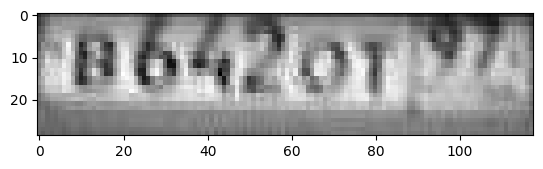

size symbols:  8


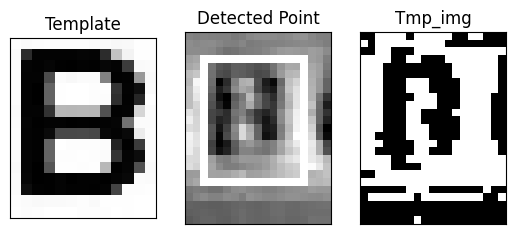

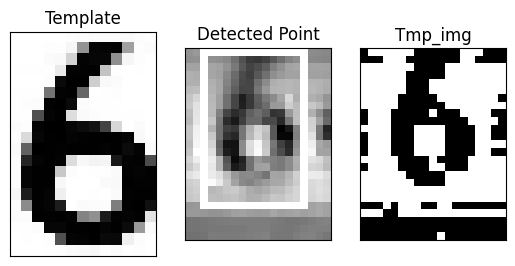

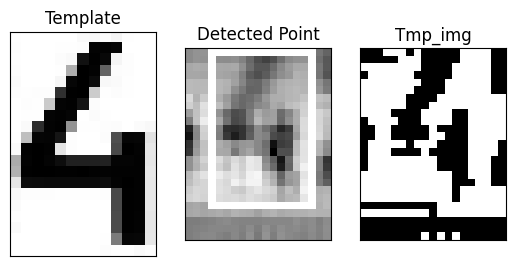

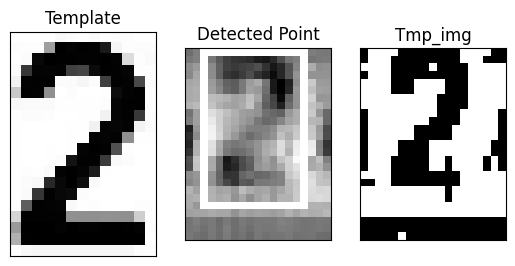

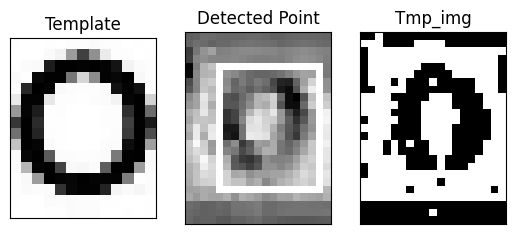

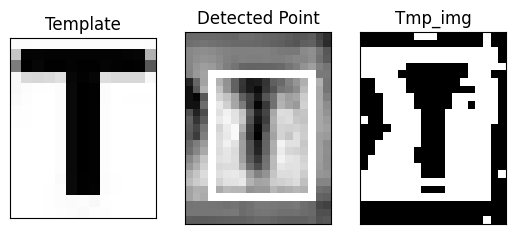

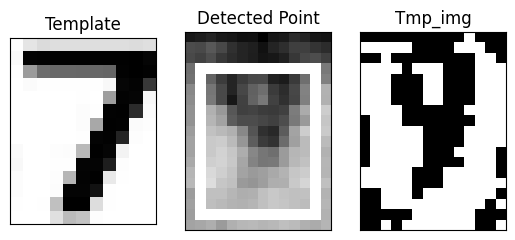

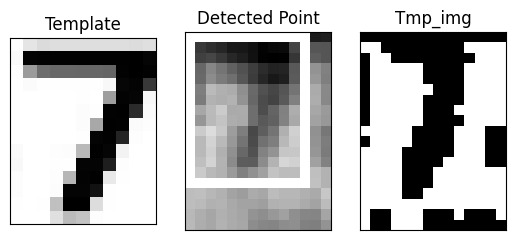

B642OT77


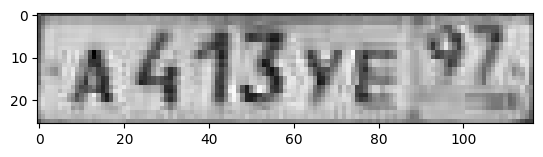

size symbols:  8


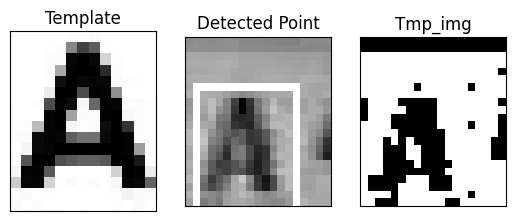

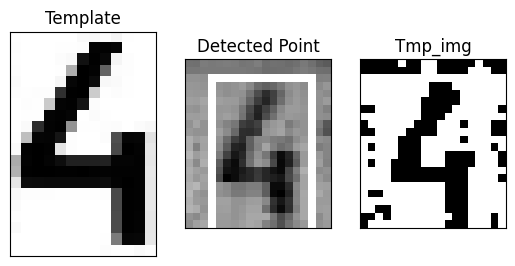

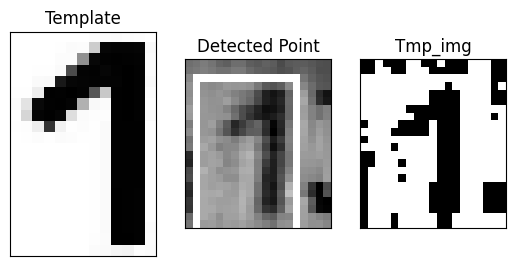

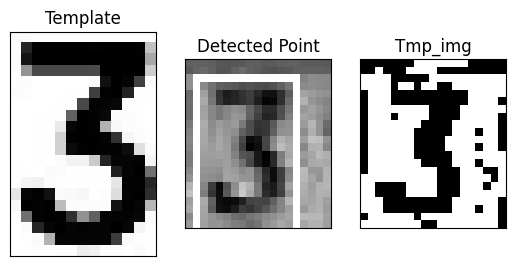

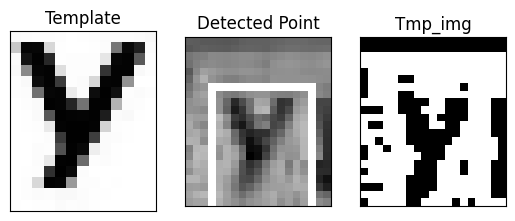

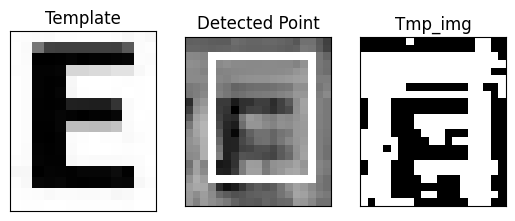

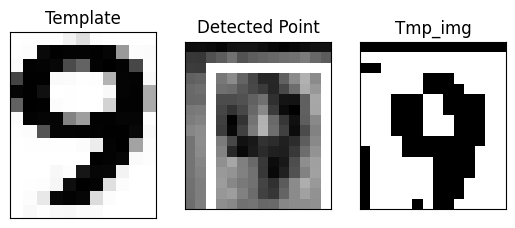

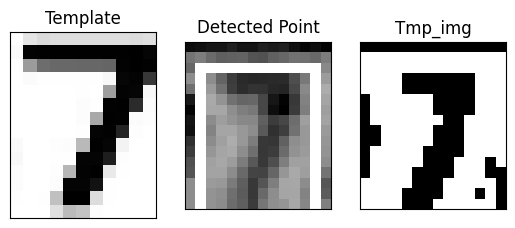

A413YE97


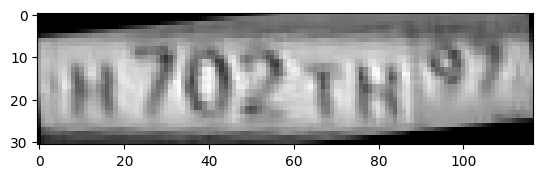

size symbols:  8


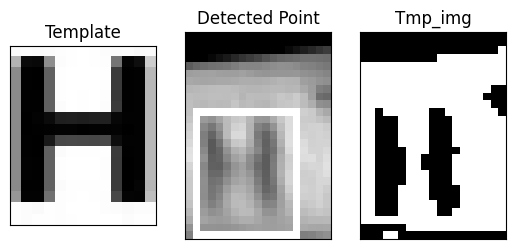

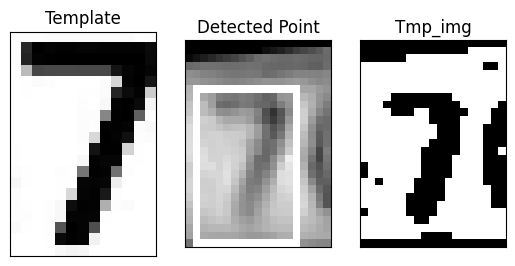

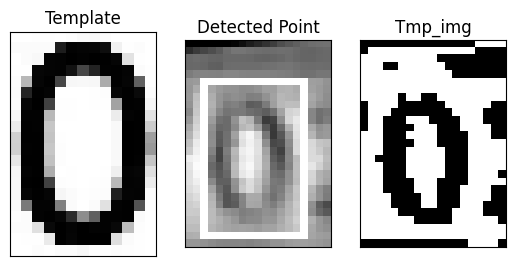

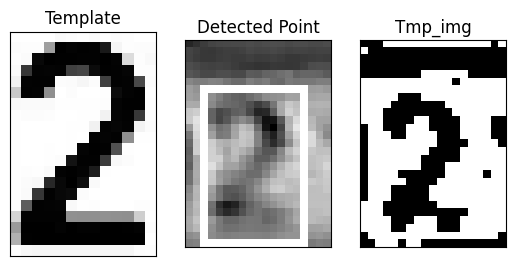

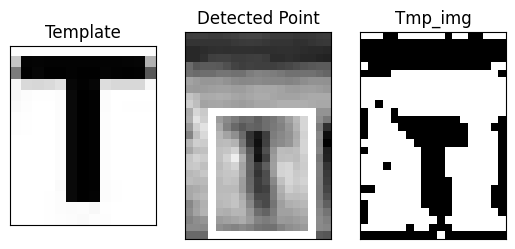

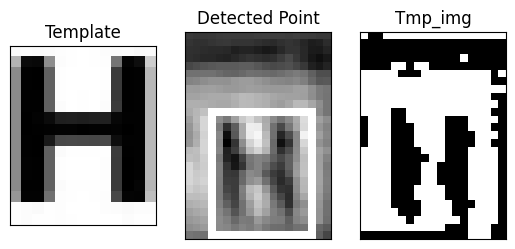

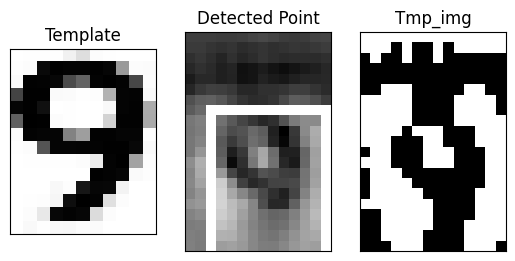

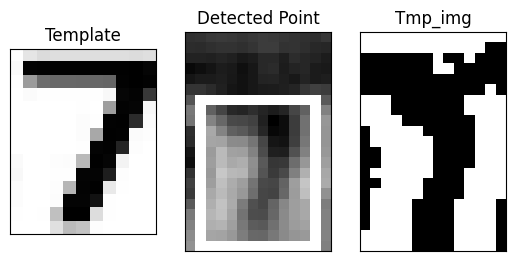

H702TH97


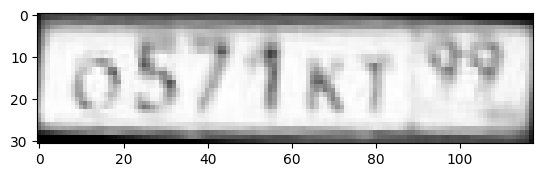

size symbols:  8


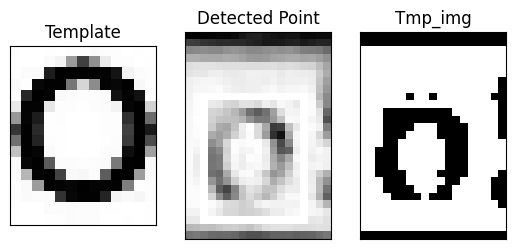

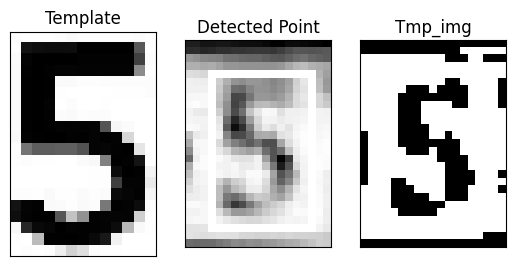

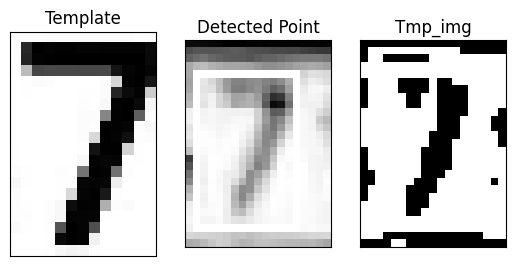

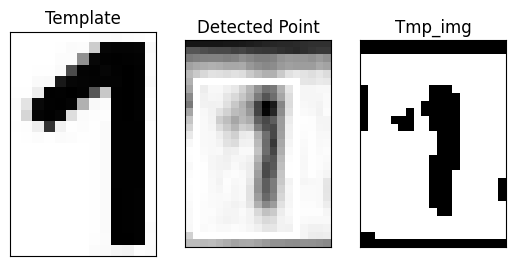

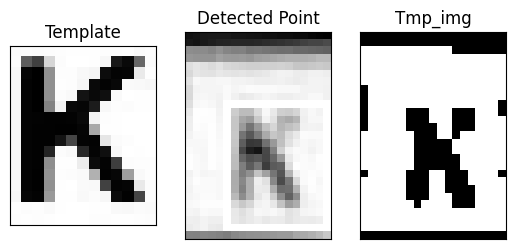

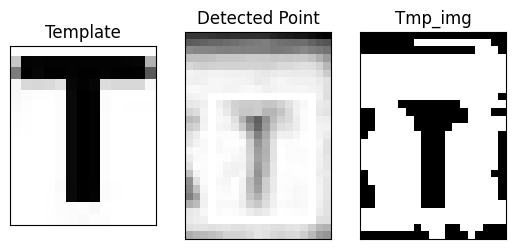

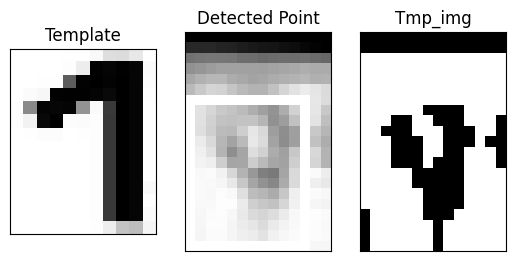

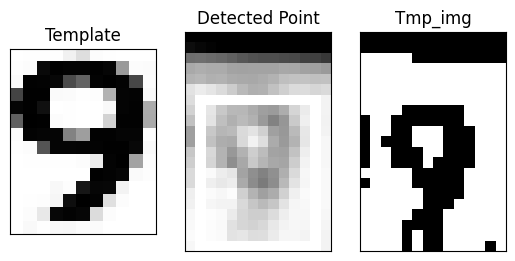

O571KT19


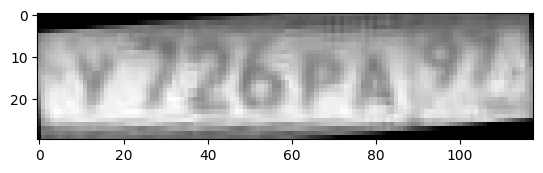

size symbols:  8


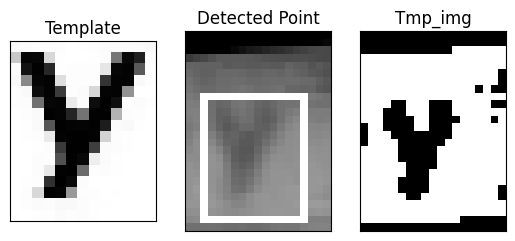

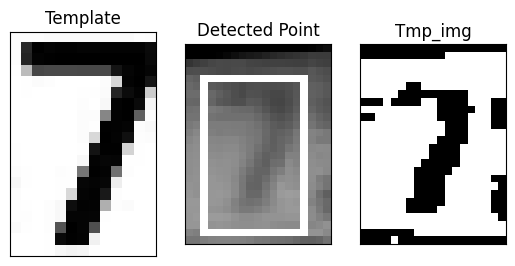

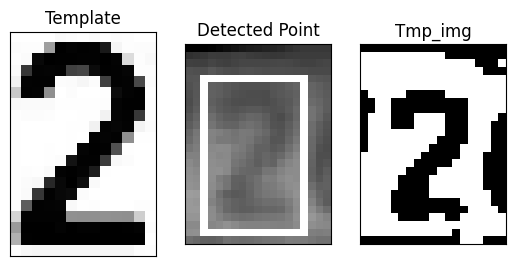

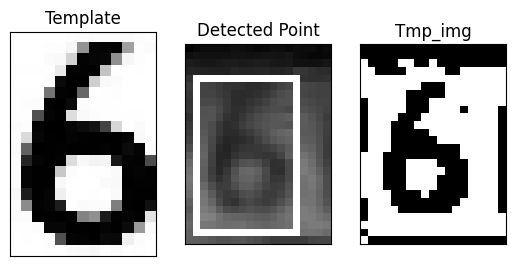

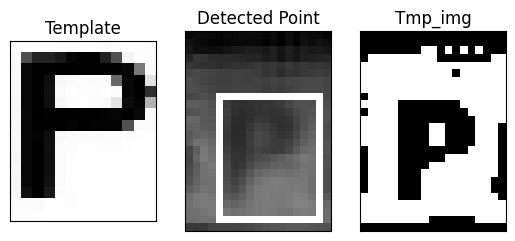

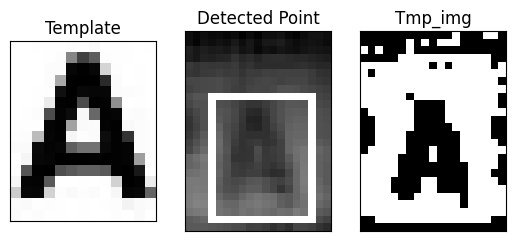

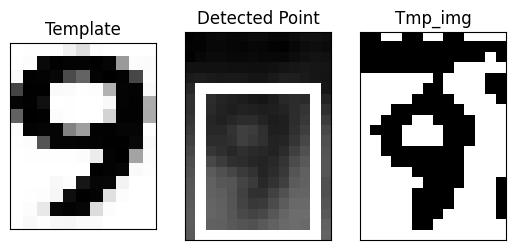

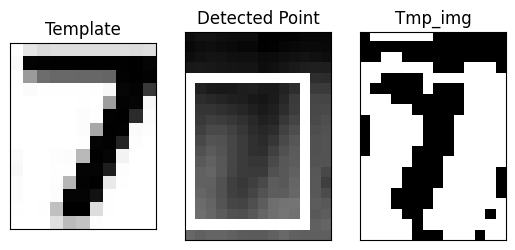

Y726PA97


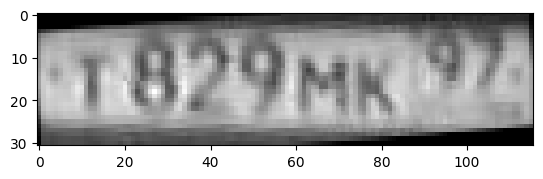

size symbols:  8


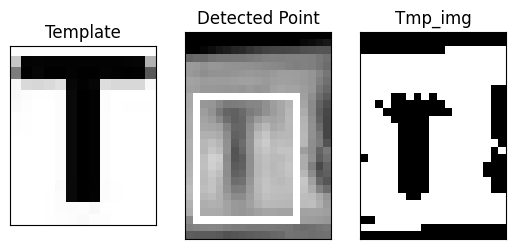

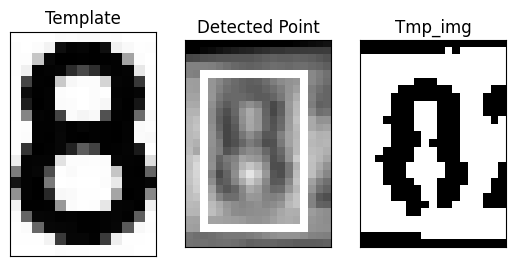

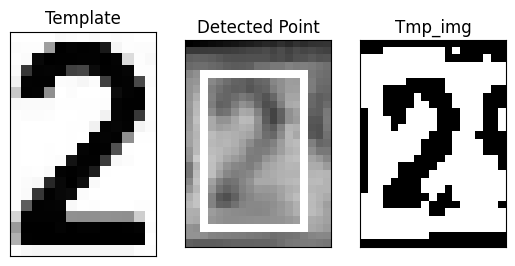

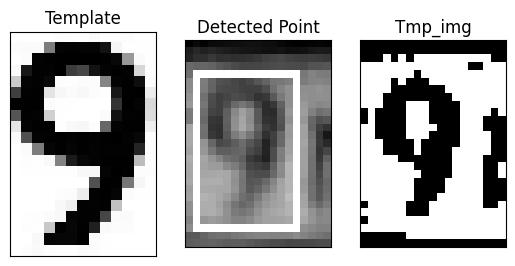

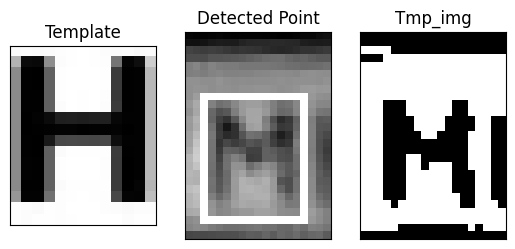

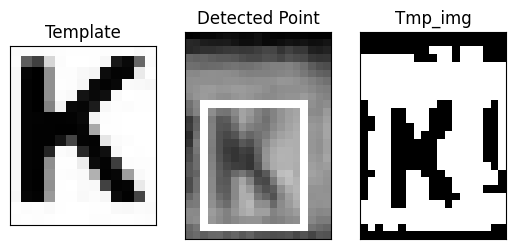

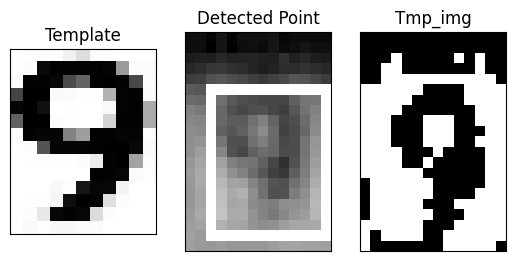

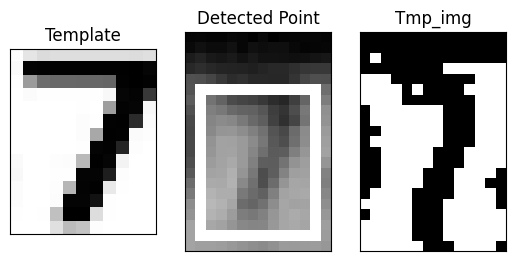

T829HK97


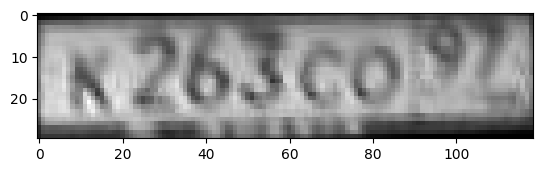

size symbols:  8


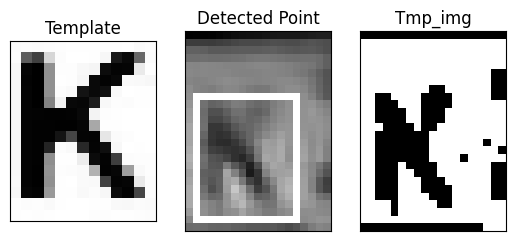

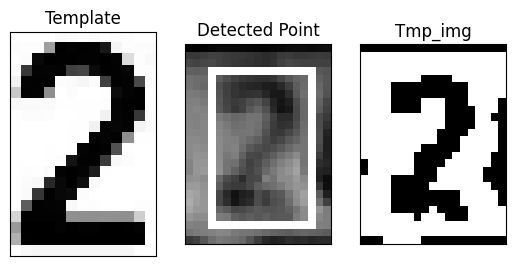

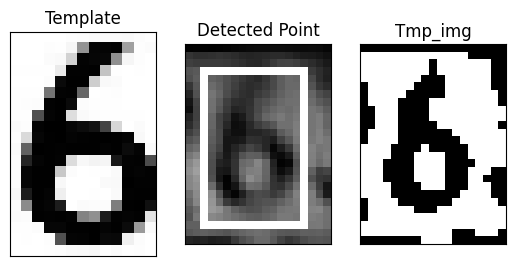

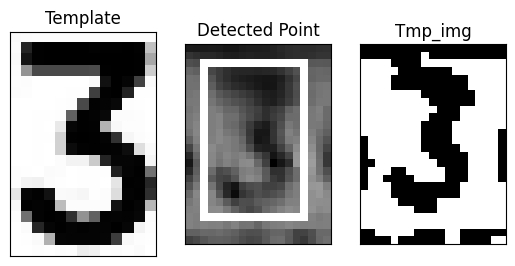

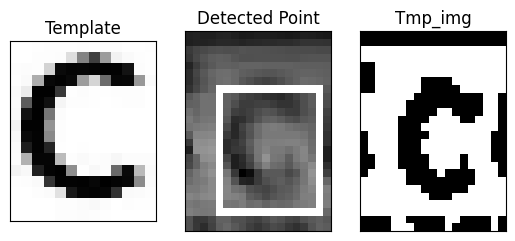

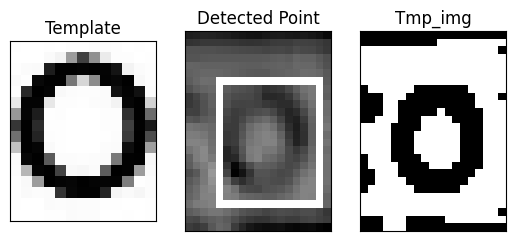

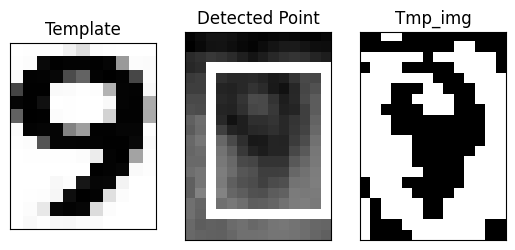

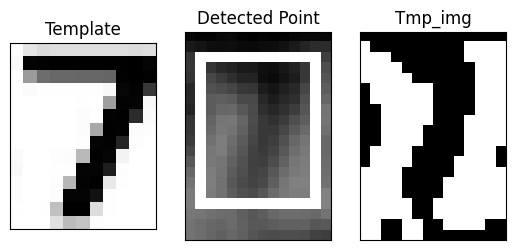

K263CO97


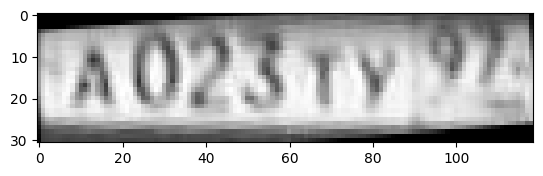

size symbols:  8


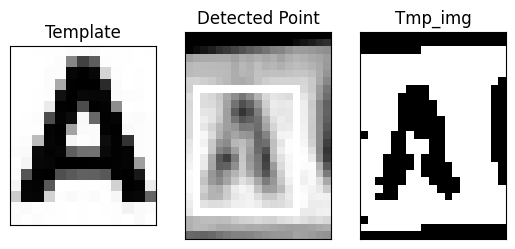

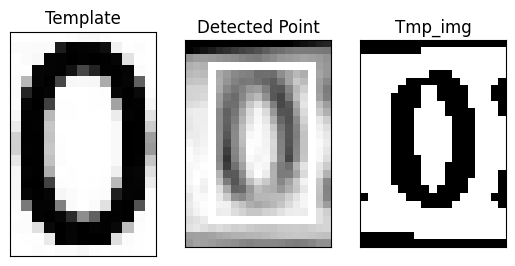

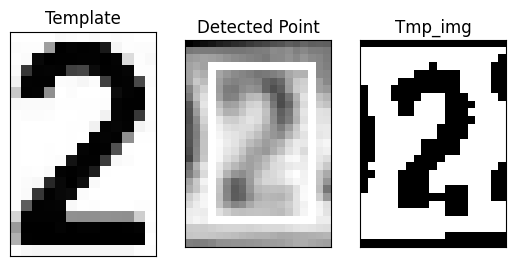

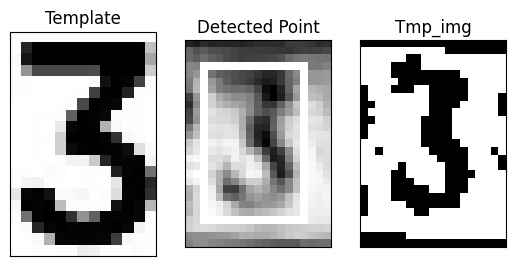

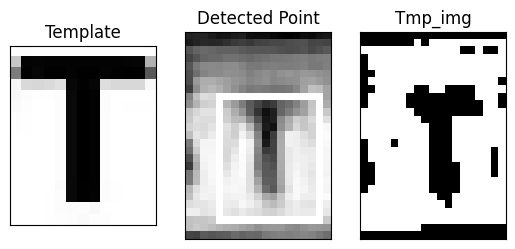

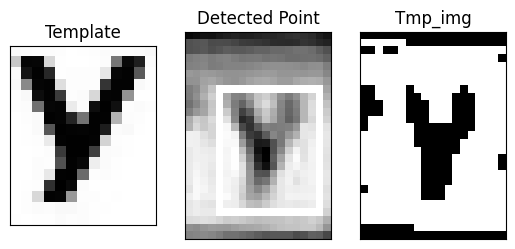

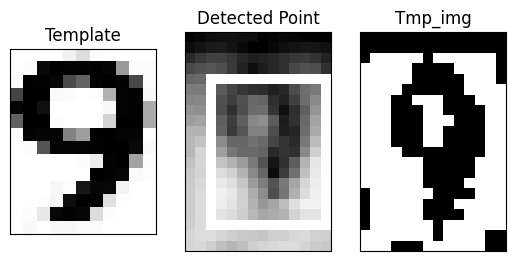

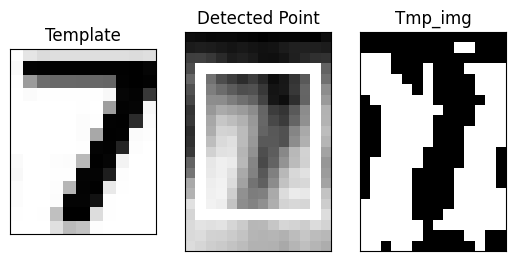

A023TY97


In [65]:
for i in range(1, 9): 
    for thr in range(60, 200, 10):  # Перебираем пороги с шагом 10.
        # print('thr: ', thr)  # Выводим текущий порог.
        img = read_img(f'img{i}.jpg', cv.IMREAD_GRAYSCALE)  
        start_img = read_img(f'img{i}.jpg', cv.IMREAD_GRAYSCALE) 
        _, img_threshold = cv.threshold(img, thr, 255, cv.THRESH_BINARY)  # Применяем пороговое преобразование.

        contours, _ = cv.findContours(img_threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)  # Находим контуры.

        cv.drawContours(img, contours, -1, (0, 100, 255), 2)  
        if find_goal_img(contours, img, start_img) != None: 
            break  
